# 1. 데이터 준비하기

`$ mkdir -p ~/aiffel/news_summarization/data`
`$ ln -s ~/data/*.csv ~/aiffel/news_summarization/data`

- 아마존 리뷰 데이터셋
- NLTK의 불용어(stopwords) 
  - NLTK : Natural Language Toolkit의 축약어
  - 영어 기호, 통계, 자연어 처리를 위한 라이브러리
  - 문장에는 자주 등장
  - 의미를 분석하고 요약하는 데는 거의 의미가 없는 100여개의 불용어가 미리 정리되어 있음
  - 이를 이용해 다운로드한 리뷰 파일에서 불용어를 제거하는 작업을 진행

In [1]:
import nltk
nltk.download('stopwords') 
# NLTK 패키지에서 불용어 사전을 다운로드

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

print('=3')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


=3


In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 :', (len(data)))
data.head()

전체 샘플수 : 98401


,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [3]:
# 추상적 요약을 하는 경우에는 text를 본문,
# headlines를 이미 요약된 데이터(실습에서는 Summary)로 삼아서 모델을 학습할 수 있어요. 
#랜덤한 15개 샘플 출력
data.sample(15)

,headlines,text
21293,"Rare, unseen pictures of late PM Atal Bihari V...",A photo gallery shows rare and unseen pictures...
4961,Trump names Patrick Shanahan as acting Defence...,US President Donald Trump has announced that D...
17924,Lala Amarnath only player in history to dismis...,Independent India's first Test captain Lala Am...
63227,Miss my legs only when I can't stand for anthe...,"Indian Paralympian Deepa Malik, who won a silv..."
47294,NZ player hits T20I fifty in less than 20 ball...,New Zealand batsman Colin Munro has become the...
37859,S Korea coach made players swap shirts to conf...,South Korean football team coach Shin Tae-yong...
21890,How will NASA's solar probe 'touch' the Sun wi...,"Launched on Sunday, NASA's Parker Solar Probe ..."
35771,NASA offers 4K resolution tour of the Moon,NASA has created a 4K resolution video tour of...
46793,Kamal Haasan launches political party in Madurai,Actor Kamal Haasan on Wednesday launched his p...
22731,I don't believe in women-oriented films: Kajol,Actress Kajol has said that she believes in go...


# 2. 데이터 전처리

## (1) 데이터 정리하기

(1-1) 빈칸으로 존재하는 null 데이터, 중복샘플(의미는 같지만 다른 식으로 작성된 글) 제거
- .nunique() :  데이터에 고유값들의 수를 출력해주는 함수, 데이터의 고유값의 총 수를 알고 싶을때 유용한 함수
  - .unique() : 데이터에 고유값들이 어떠한 종류들이 있는지 알고 싶을때 사용하는 함수, **데이터의 종류들을 알고 싶을때 사용**

- drop_duplicates() : 중복 샘플을 제거
  - inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 가 수정된 채로 저장
  
(1-2) 중복된 Null값은 삭제되나 한개의 Null은 있을수 있으니 Null값이 있는 확인하기
- .isnull().sum() : Null 값 확인
- .dropna() : 데이터프레임에서 Null을 제거

In [4]:
# 1 데이터의 중복 값 확인
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [5]:
# 2 중복값 제거
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))


전체 샘플수 : 98360


In [6]:
# 3 Null값 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


- 중복값은 없는 것으로 확인됨

## (2) 텍스트 정규화와 불용어 제거

- 텍스트 정규화(text normalization)
  - 같은 의미인데도 다른 표현으로 쓰여 마치 다른 단어들처럼 간주되는 경우(it'll = it will, mustn't= must not)
  - 미리 같은 표현으로 통일시키기
  - 기계연산량 줄이기
  -  텍스트 정규화를 위한 사전(dictionary)구성(https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)
  
- 불용어(stopwords)
  - 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어
  - 불용어제거는 자연어 처리의 성능을 높이는 방법
  
- 영어 문자는 소문자
- 섞여있는 html 태그를 제거
- 정규 표현식을 통해 각종 특수문자를 제거
- NLTK를 이용해 불용어를 제거하는 파트가 있는데, 이는 Text 전처리 시에서만 호출하고 이미 상대적으로 문장 길이가 짧은 Summary 전처리할 때는 호출하지 않을 예정
-  Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 Summary에는 남아 있는 게 더 좋음
- 함수의 인자로 remove_stopwords를 추가하고, if문을 추가
- 예문 써서 전처리 함수 작동잘되는것 확인후 
- 훈련 데이터 전체에 대해서 전처리를 수행
  - Text의 경우에는 불용어를 제거하고, Summary의 경우에는 불용어를 제거하지 않을 것이므로 
  - 따로 호출해서 진행

In [7]:
# 텍스트정규화
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [8]:
# 불용어제거
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [9]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [10]:
# 전처리 전, 후의 결과를 확인
# 임의의 text와 summary를 만들어 함수를 호출
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [11]:
# 멀티프로세싱으로 데이터 전처리진행
import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(data, remove_stopwords=True):
  start_time = time.time()
  num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

  text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
  pool.close()
  pool.join()
  print(time.time() - start_time, " seconds")
  return processed_data

clean_text = preprocess_data(data['text'])  # 클라우드 기준으로 3~4분 정도 소요 됩니다
print(clean_text)

# headlines에 대해서 전처리 함수를 호출해 줄 때는, 
# 불용어 제거를 수행하지 않는다는 의미에서 
# 두 번째 인자로 False를 넣음.
clean_headlines = preprocess_data(data['headlines'], remove_stopwords=False) 
# 클라우드 기준 1분정도 소요됩니다.
print(clean_headlines)

183.83650064468384  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak

- 텍스트 정제의 과정을 거친 후
- 다시 한번 빈(empty) 샘플이 생겼는지 확인
- 정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우 -> 샘플 자체가 빈 값을 가지게 됨

In [12]:
# 빈(empty) 샘플이 생겼는지 확인
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

#Null값 확인
data.isnull().sum()

# 빈 샘플들은 모두 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


## (3) 훈련데이터와 테스트데이터 나누기

(3-1) 샘플의 최대 길이 정하기
- text와 headlines의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
headlines의 최소 길이 : 1
headlines의 최대 길이 : 16
headlines의 평균 길이 : 9.299532330215534


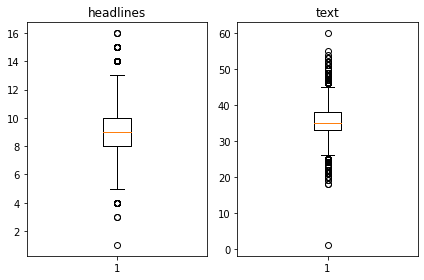

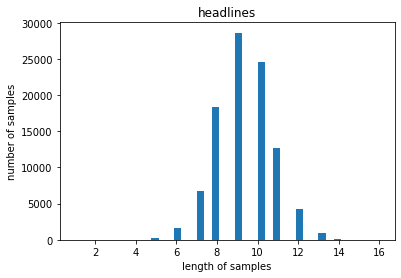

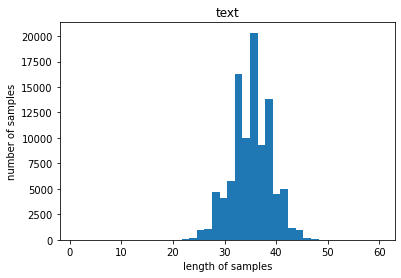

In [13]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('headlines의 최소 길이 : {}'.format(np.min(headlines_len)))
print('headlines의 최대 길이 : {}'.format(np.max(headlines_len)))
print('headlines의 평균 길이 : {}'.format(np.mean(headlines_len)))

# 요약 길이분포
plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')

# 실제 텍스트길이 분포
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

# 요약본 샘플 길이별 갯수
plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

# 실제 텍스트 샘플 길이별 갯수
plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- `요약본(headlines) 샘플 길이별 갯수`와 `실제 텍스트(text) 샘플 길이별 갯수시각화` 그래프를 통해 대체적으로 몰려있는 몇 이하의 길이를 확인할수있다.

- headlines 는 8자~12자 사이, text는 45자

In [14]:
# text의 최대 길이와 headlines의 적절한 최대 길이를 임의로 지정
text_max_len = 45
headlines_max_len = 13

- 임의로 지정한 길이 선택시 
- 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 
- 통계로 확인하는 편이 객관적으로 길이를 결정하는 데 도움이 됨
- 훈련 데이터와 샘플의 길이를 입력
- 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단하기

In [15]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [16]:
# 위에서 만든 함수를 text와 headlines에 적용 
# 임의로 결정한 길이가 몇 % 샘플까지 포함하는지 확인

below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.9981699877999186


- 임의이 길이 이하인 샘플의 비율에서 100을 빼면 그 나머지 샘플들의 내용이 망가진다는것
- 정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터 정제

In [17]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 97863


(3-2) 시작 토큰과 종료 토큰 추가하기
- eq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있어요. 이번 실습에서는 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞, 뒤로 추가할 거예요. 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input, 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target이라고 이름을 정했어요. 두 개의 문장 모두 headlines 열로부터 만들 거예요.

In [18]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [19]:
# 인코더 입력, 디코더 입력 레이블 각각 Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [20]:
# 훈련 데이터와 테스트 데이터를 분리
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[92734 36771 21469 ... 22617 43393 11945]


In [21]:
# 이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의하여 잘 섞인 샘플만들기
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [22]:
#8:2의 비율로 훈련 데이터와 테스트 데이터로 분리
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19572


In [23]:
#테스트 데이터의 개수를 이용해 전체 데이터를 양분
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78291
훈련 레이블의 개수 : 78291
테스트 데이터의 개수 : 19572
테스트 레이블의 개수 : 19572


## (4) 정수 인코딩
(4-1)단어 집합(vocabulary) 만들기 및 정수 인코딩
- 단어 집합(vocabulary) 을 만들기
  - 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸기
  - 각 단어에 고유한 정수를 맵핑하는 작업
  - 훈련 데이터에 대해서 단어 집합을 만들기
  - 원문에 해당되는 encoder_input_train에 대해서 단어 집합을 만들기
  - Keras의 토크나이저를 사용하여 입력된 훈련 데이터로부터 단어 집합을 만들기
  

In [24]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) 
# 입력된 데이터로부터 단어 집합 생성

- 정수부여 완료
 - 현재 생성된 단어 집합은 src_tokenizer.word_index에 저장
 - 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행
 - 등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
 - 통계적인 정보확인 : `src_tokenizer.word_counts.items()`사용, 단어와 각 단어의 등장 빈도수가 저장되어있음

In [25]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69380
등장 빈도가 6번 이하인 희귀 단어의 수: 47240
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22140
단어 집합에서 희귀 단어의 비율: 68.08878639377343
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.481836714768881


- 등장 빈도가 threshold 값인 7회 미만, 즉, 6회 이하인 단어들은 단어 집합에서 무려 68%를 차지
- 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.5%
- 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고,
- 훈련 데이터에서 제거
  - 위에서 이를 제외한 단어 집합의 크기를 2만2천여 개로 계산했는데, 
  - 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 22,000으로 제한
  - 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한함
  
- texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행
- 현재 단어 집합의 크기를 22,000으로 제한했으니까 이제 22,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않음

In [26]:
src_vocab = 22000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 22,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력 - 잘되면 텍스트데이터가 아닌 정수로 출력됨
print(encoder_input_train[:3])

[[6776, 12490, 9637, 193, 2112, 292, 9124, 278, 311, 1087, 19, 290, 709, 1875, 1469, 13748, 9637, 55, 152, 1969, 242, 5677, 12147, 16632, 41, 185, 75, 31, 23, 5430], [320, 4493, 175, 2861, 1518, 1340, 79, 20681, 20682, 1, 328, 818, 1518, 1396, 4, 345, 103, 841, 125, 1518, 12, 1340, 908, 1780, 386, 3046, 539], [206, 83, 52, 7766, 3410, 1428, 4744, 743, 584, 92, 2508, 144, 1504, 571, 358, 5471, 4218, 287, 497, 5859, 1429, 401, 139, 674, 52, 584, 1793, 2107, 7881, 3410, 330, 1]]


In [27]:
# headlines 에도 동일한 작업 수행, 전체단어집합과 각 단어에 대한 빈도수계산
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었어요. 이는 tar_tokenizer.word_index에 저장되어 있어요. tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻어서, 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼게요.

In [28]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29987
등장 빈도가 5번 이하인 희귀 단어의 수: 19655
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10332
단어 집합에서 희귀 단어의 비율: 65.54506953012972
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.6900199266253235


- 등장빈도가 5회 이하인 단어들은 단어집합에서 65% 차지하고 잇음
- 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 작은 수치 4.67%
- 희귀단어 제외하여 10000개의 단어집합의 크기로 제한

In [29]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 28, 357, 1087, 8140, 8766, 549], [1, 48, 80, 1212, 1181, 1161, 80, 1320, 3403, 78], [1, 533, 1902, 391, 15, 3561, 3784, 2437], [1, 128, 272, 175, 3, 1738, 2279, 4, 55], [1, 29, 483, 513, 13, 15, 1442, 1088, 5377, 4005]]
target
decoder  [[28, 357, 1087, 8140, 8766, 549, 2], [48, 80, 1212, 1181, 1161, 80, 1320, 3403, 78, 2], [533, 1902, 391, 15, 3561, 3784, 2437, 2], [128, 272, 175, 3, 1738, 2279, 4, 55, 2], [29, 483, 513, 13, 15, 1442, 1088, 5377, 4005, 2]]


- 현재 decoder_input_train과 decoder_target_train에는 더 이상 숫자 10,000이 넘는 숫자들은 존재하지 않음
- 패딩하기 하기 전 점검할것
  - 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있음
  - 길이가 상대적으로 길었던 원문(Text)의 경우에는 문제가 별로 없겠지만, 애초에 평균 길이가 13밖에 되지 않았던 요약문(headlines)의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높음
  - 요약문에서 길이가 0이 된 샘플들의 인덱스를 받아보기
  - 주의점
    - 요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않아
    - 길이가 0이 된 요약문의 실제 길이는 1로 나옴
    - 길이 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아 있음  
  - 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장 후 삭제할 예정  

In [30]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78291
훈련 레이블의 개수 : 78291
테스트 데이터의 개수 : 19572
테스트 레이블의 개수 : 19572


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(4-2)패딩하기 
- 텍스트 시퀀스 정수 시퀀스로 변환 했다면 서로 다른 길이의 샘플들을 병렬처리 하기위해 같은 길이로 맞춰주는 패딩작업을 해주어야함
- 아까 정해주었던 최대길이로 패딩함,
- 최대 길이보다 짧은 데이터들은 앞의 공간에 숫자 0을 넣어 최대길이로 맞춰줌.

In [31]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='pre')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='pre')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='pre')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='pre')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='pre')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='pre')

# 3. 모델 설계하기


In [32]:
# 모델설계

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [33]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [34]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [35]:
#어텐션 메커니즘
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [36]:
# 설계한 디코더 출력층 다음과 같이 수정

# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

# 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용
# 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

# 4. 모델훈련하기
- Early stopping 이용해서 모델 훈련의 최적점에서 멈추게 하기
  - val_loss(검증 데이터의 손실)을 관찰하다가 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정

In [37]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
306/306 [==============================] - 251s 785ms/step - loss: 5.5797 - val_loss: 4.8513
Epoch 2/50
306/306 [==============================] - 238s 777ms/step - loss: 4.8657 - val_loss: 4.7169
Epoch 3/50
306/306 [==============================] - 232s 759ms/step - loss: 4.7327 - val_loss: 4.6109
Epoch 4/50
306/306 [==============================] - 229s 749ms/step - loss: 4.6131 - val_loss: 4.5600
Epoch 5/50
306/306 [==============================] - 225s 735ms/step - loss: 4.4864 - val_loss: 4.4140
Epoch 6/50
306/306 [==============================] - 229s 750ms/step - loss: 4.3773 - val_loss: 4.3251
Epoch 7/50
306/306 [==============================] - 231s 755ms/step - loss: 4.2859 - val_loss: 4.2596
Epoch 8/50
306/306 [==============================] - 228s 745ms/step - loss: 4.2016 - val_loss: 4.2151
Epoch 9/50
306/306 [==============================] - 225s 737ms/step - loss: 4.1402 - val_loss: 4.1752
Epoch 10/50
306/306 [==============================] - 230s 752m

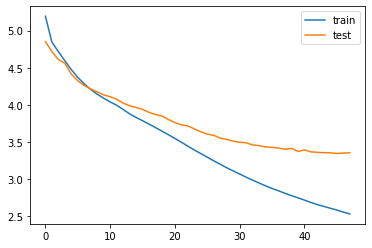

In [38]:
# 훈련데이터의 손실과 검증데이터의 손실이 줄어드는 과정 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 5. 인퍼런스 모델구현
- 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비

- seq2seq : 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 함
- 훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있음 -> 인코더와 디코더를 엮은 통짜 모델 하나만 준비

- 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작-> 인퍼런스를 위한 모델 설계를 별도로 해야함. 이때는 인코더 모델과 디코더 모델을 분리해서 설계함

In [39]:
src_index_to_word = src_tokenizer.index_word 
# 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index 
# 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word
# 요약 단어 집합에서 정수 -> 단어를 얻음

In [40]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [41]:
# 어텐션 메커니즘 사용하는 출력층 설계

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [45]:
# 인퍼런스 단계에서 단어 시퀀스 완성하는 함수 만들기
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# 6. 모델 테스트하기

- 테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인
- 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들기
  - 함수를 만들 때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 
  - headlines의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만들기

In [46]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [47]:
#테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : two bjp ministers decided quit andhra pradesh assembly cm chandrababu naidu requested continue work welfare state ministers worked good state brought considerable reforms departments naidu said comes tdp ministers decided resign union cabinet demand special status andhra pradesh 
실제 요약 : andhra cm urges bjp mlas to not resign from state cabinet 
예측 요약 :  andhra cm to step down as bjp chief secy for andhra polls


원문 : christian von head supercar maker said tesla roadster performance reaching nearly kmph seconds embarrassing said wondered whether possible yeah possible company currently produces kmph acceleration seconds 
실제 요약 : tesla is embarrassing us supercar maker 
예측 요약 :  tesla car to be made in the world st car in yrs


원문 : supreme court criticised bihar government taking proper action shelter homes children allegedly sexually abused accused state going soft perpetrators apex court termed bihar government conduct shameful inhuman noting children allegedly sodomised police 

예측 요약 :  nba star to be paid for lakh for yrs in yrs ago


원문 : engineering company cotton announced acquire majority stake coimbatore based electric two wheeler maker vehicles investors include tata sons chairman emeritus ratan tata infosys co founder kris gopalakrishnan initially acquire crore may buy another stake crore span years 
실제 요약 : to buy ratan tata backed vehicles 
예측 요약 :  tata motors profit rises to cr in sept quarter of ipo report


원문 : us based scientists used organ proteins develop tissue papers thin flexible enough fold like origami various papers made ovarian kidney liver heart proteins obtained processing pig cow organs could used wound healing aiding tissue support hormone production cancer patients researchers said 
실제 요약 : tissue papers could study 
예측 요약 :  scientists find new york city can be used to acquire brain cells


원문 : users reported bluetooth headphone microphone connected pixel devices microphone fails detect voice preventing operating google assista

예측 요약 :  us to build nuclear test for st time in years in korea


원문 : congress leader randeep surjewala wednesday hit bjp asking pm narendra modi party national president amit shah would apologise bjp leader nityanand rai chop fingers remarks rai threatened chop fingers hands raised pm modi however rai later retracted statement saying regretted 
실제 요약 : will pm modi apologise for rai fingers remark cong 
예측 요약 :  amit shah to meet bjp leader on rahul gandhi at shah meet


원문 : chinese president xi jinping promised cut import tariffs introduce moves make easier foreign firms access country economy amid trade war us protectionism rising free trade system threat said adding chinese economy sea pond 
실제 요약 : china to lower import tariffs open market amid trade war with us 
예측 요약 :  china trade war with us citizens to be ready for trade war


원문 : music festival organisers uk planning allow people test illegal drugs attempt reduce drug related deaths people able take drugs testing tent tol

# 7. Summa 이용한 추출척 요약해보기
- 추출척 요약 : 텍스트 요약에는 추상적 요약 외에도 이미 본문에 존재하는 단어구, 문장을 뽑아서 요약으로 삼는다
- 패키지 Summa에서는 추출적 요약을 위한 모듈인 summarize를 제공
  - 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행
  - 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있음
  - Summa의 summarize()의 인자
    - text (str) : 요약할 테스트.
    - ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
    - words (int or None, optional) – 출력에 포함할 단어 수. 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
    - split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

In [52]:
#  비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄임
#  원문의 0.005%만을 출력하도록 설정
from summa.summarizer import summarize
import requests
text = requests.get("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv").text
print(text[:1500])


headlines,text
upGrad learner switches to career in ML & Al with 90% salary hike,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."
Delhi techie wins free food from Swiggy for one year on CRED,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more."
New Zealand end Rohit Sharma-led India's 12-match winning streak,"New Zealand defeated India by 8 wickets in the fourth ODI at Ham

In [ ]:
print('Summary:')
print(summarize(text, ratio=0.0005))

In [ ]:
# 리스트로 출력 결과 받기 (split 인자값을 True)로 
print('Summary:')
print(summarize(text, ratio=0.0005, split=True))
# 단어의 수로 요약문의 크기를 조절


In [ ]:
# 단어를 50개만 선택
print('Summary:')
print(summarize(text, words=30))